# Import libraries

In [1]:
import numpy as np
import pandas as pd

import datetime
import requests
from prettytable import PrettyTable

import zipfile

# pipeline construction
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)

# Functions

In [2]:
def return_last_value(column, first_date = '2001-02-04'):
    index = dataset[:first_date][[column]].last_valid_index()
    value = dataset.loc[index][column]
    print(f'{index}: {column} = {value}')
    return value

# Adding data variables

In [3]:
path_data_variables = 'data/variables_data/'

In [4]:
### Stock exchange indices ###

# WIG20 Total Return
# from: https://stooq.com/q/d/?s=wig20tr&c=0
wig20tr_d = pd.read_csv(path_data_variables+'wig20tr_d.csv')

# S&P 500 
# from: https://stooq.com/q/d/?s=%5Espx&c=0
spx_d = pd.read_csv(path_data_variables+'^spx_d.csv')
spx_d.columns = spx_d.columns.map(lambda x : 'spx_' + x if x !='Date' else x)

# DAX 
# from: https://stooq.com/q/d/?s=%5Edax&c=0
dax_d = pd.read_csv(path_data_variables+'^dax_d.csv')
dax_d.columns = dax_d.columns.map(lambda x : 'dax_' + x if x !='Date' else x)

### Leading indicators ###

# PMI for Poland in months
# from: https://stooq.com/q/d/?s=pmmnpl.m&c=0
pmi_pl = pd.read_csv(path_data_variables+'pmmnpl_m_d.csv')
pmi_pl = pmi_pl.drop(columns=['High', 'Low', 'Open'])
pmi_pl.rename({'Close': 'PMI_PL'}, axis=1, inplace=True)

# PMI for USA in months
# from: https://stooq.com/q/d/?s=pmchus.m&c=0
pmi_us = pd.read_csv(path_data_variables+'pmchus_m_d.csv')
pmi_us = pmi_us.drop(columns=['High', 'Low', 'Open'])
pmi_us.rename({'Close': 'PMI_US'}, axis=1, inplace=True)

# CLI for Poland in months
# from: https://fred.stlouisfed.org/series/POLLOLITONOSTSAM
cli_pl = pd.read_csv(path_data_variables+'POLLOLITONOSTSAM.csv')
cli_pl.rename({'DATE': 'Date', 'POLLOLITONOSTSAM': 'CLI_PL'}, axis=1, inplace=True)

### Fundamental data ###

# P/E for WIG20 
# from: https://stooq.com/q/d/?s=wig20_pe&c=0
wig20_pe_d = pd.read_csv(path_data_variables+'wig20_pe_d.csv')
wig20_pe_d = wig20_pe_d.drop(columns=['High', 'Low', 'Open'])
wig20_pe_d.rename({'Close': 'WIG_20_P/E'}, axis=1, inplace=True)

# P/BV for WIG20 
# from: https://stooq.com/q/d/?s=wig20_pb&c=0
wig20_pb_d = pd.read_csv(path_data_variables+'wig20_pb_d.csv')
wig20_pb_d = wig20_pb_d.drop(columns=['High', 'Low', 'Open'])
wig20_pb_d.rename({'Close': 'WIG_20_P/BV'}, axis=1, inplace=True)

# DIVIDEND YIELD for WIG20 
# from: https://stooq.com/q/d/?s=wig20_pb&c=0
wig20_dy_d = pd.read_csv(path_data_variables+'wig20_dy_d.csv')
wig20_dy_d = wig20_dy_d.drop(columns=['High', 'Low', 'Open'])
wig20_dy_d.rename({'Close': 'WIG_20_DY'}, axis=1, inplace=True)

### Other indicators that indicate the phase of the cycle ###

# Financial Assets relative to disposable personal income
# from: https://fred.stlouisfed.org/graph/?graph_id=307643
assets_to_personal_income = pd.read_csv(path_data_variables+'assets_to_personal_income.csv')
assets_to_personal_income.rename({'DATE': 'Date', 'TFAABSHNO_DSPI': 'assets_to_personal_income'}, axis=1, inplace=True)

# 10-Year Poland Treasury Yield
# from: https://pl.investing.com/rates-bonds/poland-10-year-bond-yield-historical-data
treasury_yield_10 = pd.read_csv(path_data_variables+'treasury_yield_10.csv', decimal=",")
treasury_yield_10 = treasury_yield_10.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Zmiana%'])
treasury_yield_10.rename({'Data': 'Date', 'Ostatnio': 'treasury_yield_10'}, axis=1, inplace=True)
treasury_yield_10 = treasury_yield_10[::-1].reset_index(drop=True)
treasury_yield_10['Date']= pd.to_datetime(treasury_yield_10['Date'], format='%d.%m.%Y')
treasury_yield_10['Date'] = treasury_yield_10['Date'].astype(str)

# 2-Year Poland Treasury Yield
# from: https://pl.investing.com/rates-bonds/poland-2-year-bond-yield-historical-data
treasury_yield_2 = pd.read_csv(path_data_variables+'treasury_yield_2.csv', decimal=",")
treasury_yield_2 = treasury_yield_2.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Zmiana%'])
treasury_yield_2.rename({'Data': 'Date', 'Ostatnio': 'treasury_yield_2'}, axis=1, inplace=True)
treasury_yield_2 = treasury_yield_2[::-1].reset_index(drop=True)
treasury_yield_2['Date']= pd.to_datetime(treasury_yield_2['Date'], format='%d.%m.%Y')
treasury_yield_2['Date'] = treasury_yield_2['Date'].astype(str)

In [5]:
wig20tr_d

,Date,Open,High,Low,Close,Volume
0,2004-12-31,1960.57,1960.57,1960.57,1960.57,2925638.0
1,2005-01-03,1966.69,1966.69,1966.69,1966.69,6689831.0
2,2005-01-04,1954.80,1954.80,1954.80,1954.80,6351533.0
3,2005-01-05,1910.33,1910.33,1910.33,1910.33,8513079.0
4,2005-01-06,1897.29,1897.29,1897.29,1897.29,7933010.0
...,...,...,...,...,...,...
4013,2021-01-19,3746.76,3746.76,3626.70,3626.70,32703284.0
4014,2021-01-20,3642.58,3655.91,3591.53,3637.63,26554080.0
4015,2021-01-21,3669.81,3675.13,3569.97,3577.93,25603661.0
4016,2021-01-22,3547.57,3598.99,3544.84,3576.42,21137609.0


In [7]:
datasets = {'wig20tr_d':wig20tr_d, 'spx_d':spx_d, 'dax_d':dax_d, 'pmi_pl':pmi_pl, 'pmi_us':pmi_us, 'cli_pl':cli_pl,
            'wig20_pe_d':wig20_pe_d, 'wig20_pb_d':wig20_pb_d, 'wig20_dy_d':wig20_dy_d,
            'assets_to_personal_income':assets_to_personal_income,
            'treasury_yield_10':treasury_yield_10, 'treasury_yield_2':treasury_yield_2}
t = PrettyTable(['Dataset', 'First time'])
for key in datasets:
    df = datasets[key].copy()
    t.add_row([key, df["Date"].iloc[0]])
print(t)

+---------------------------+------------+
|          Dataset          | First time |
+---------------------------+------------+
|         wig20tr_d         | 2004-12-31 |
|           spx_d           | 1789-05-01 |
|           dax_d           | 1959-09-28 |
|           pmi_pl          | 1998-07-31 |
|           pmi_us          | 2001-01-31 |
|           cli_pl          | 1991-06-01 |
|         wig20_pe_d        | 2007-10-19 |
|         wig20_pb_d        | 2007-10-19 |
|         wig20_dy_d        | 2007-08-23 |
| assets_to_personal_income | 1960-01-01 |
|     treasury_yield_10     | 2005-12-26 |
|      treasury_yield_2     | 2005-12-26 |
+---------------------------+------------+


In [9]:
dataset = pd.merge(wig20tr_d, spx_d, how='inner', on='Date')
dataset = pd.merge(dataset, dax_d, how='inner', on='Date')
dataset = pd.merge(dataset, pmi_pl, how='outer', on='Date')
dataset = pd.merge(dataset, pmi_us, how='outer', on='Date')
dataset = pd.merge(dataset, cli_pl, how='outer', on='Date')
dataset = pd.merge(dataset, wig20_pe_d, how='outer', on='Date')
dataset = pd.merge(dataset, wig20_pb_d, how='outer', on='Date')
dataset = pd.merge(dataset, wig20_dy_d, how='outer', on='Date')
dataset = pd.merge(dataset, assets_to_personal_income, how='outer', on='Date')
dataset = pd.merge(dataset, treasury_yield_10, how='outer', on='Date')
dataset = pd.merge(dataset, treasury_yield_2, how='outer', on='Date')

dataset = dataset.set_index('Date')
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d')
dataset.sort_index(inplace=True)

first_date = '2007-10-19'
last_date = '2021-01-25'

dataset.loc[first_date, 'PMI_PL'] = return_last_value(column = 'PMI_PL', first_date = first_date)
dataset.loc[first_date, 'PMI_US'] = return_last_value(column = 'PMI_US', first_date = first_date)
dataset.loc[first_date, 'CLI_PL'] = return_last_value(column = 'CLI_PL', first_date = first_date)
dataset.loc[first_date, 'assets_to_personal_income'] = return_last_value(column = 'assets_to_personal_income', first_date = first_date)

dataset = dataset.loc[first_date:last_date].copy()
dataset

2007-09-28 00:00:00: PMI_PL = 51.5
2007-09-28 00:00:00: PMI_US = 54.2
2007-10-01 00:00:00: CLI_PL = 100.809682080826
2007-10-01 00:00:00: assets_to_personal_income = 5.123740799339616


,Open,High,Low,Close,Volume,spx_Open,spx_High,spx_Low,spx_Close,spx_Volume,dax_Open,dax_High,dax_Low,dax_Close,dax_Volume,PMI_PL,PMI_US,CLI_PL,WIG_20_P/E,WIG_20_P/BV,WIG_20_DY,assets_to_personal_income,treasury_yield_10,treasury_yield_2
Date,,,,,,,,,,,,,,,,,,,,,,,,
2007-10-19,4379.67,4379.67,4379.67,4379.67,29456097.0,1540.08,1540.08,1500.26,1500.63,2.311650e+09,7895.52,7940.29,7870.73,7884.12,268825856.0,51.5,54.2,100.809682,21.958,3.741,2.055,5.123741,5.715,5.359
2007-10-22,4362.07,4362.07,4362.07,4362.07,37825830.0,1500.63,1508.06,1490.40,1506.33,1.928794e+09,7819.27,7819.27,7763.64,7794.93,294604256.0,NaN,NaN,NaN,21.886,3.723,2.060,NaN,5.628,5.321
2007-10-23,4476.13,4476.13,4476.13,4476.13,31809295.0,1506.33,1520.01,1503.61,1519.59,1.838400e+09,7822.89,7876.62,7822.89,7842.79,243051520.0,NaN,NaN,NaN,22.344,3.799,2.005,NaN,5.502,5.317
2007-10-24,4443.34,4443.34,4443.34,4443.34,26511409.0,1519.59,1519.59,1489.56,1515.88,2.224056e+09,7842.12,7861.27,7807.99,7828.96,257861712.0,NaN,NaN,NaN,22.178,3.772,2.015,NaN,5.497,5.378
2007-10-25,4468.73,4468.73,4468.73,4468.73,29651370.0,1515.88,1523.24,1500.46,1514.40,2.324422e+09,7862.60,7970.56,7861.39,7932.43,401154880.0,NaN,NaN,NaN,22.141,3.765,1.985,NaN,5.473,5.417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,3746.76,3746.76,3626.70,3626.70,32703284.0,3781.88,3804.53,3780.37,3798.91,2.485142e+09,13935.93,13940.05,13804.46,13815.06,NaN,NaN,NaN,NaN,24.783,1.426,0.655,NaN,1.183,0.091
2021-01-20,3642.58,3655.91,3591.53,3637.63,26554080.0,3816.22,3859.75,3816.22,3851.85,2.350472e+09,13848.77,13952.20,13835.99,13921.37,NaN,NaN,NaN,NaN,24.812,1.436,0.655,NaN,1.196,0.089
2021-01-21,3669.81,3675.13,3569.97,3577.93,25603661.0,3857.46,3861.45,3845.05,3853.07,2.591056e+09,13997.78,14026.35,13878.84,13906.67,NaN,NaN,NaN,NaN,24.465,1.405,0.670,NaN,1.238,0.106


In [10]:
dataset.isna().sum()

Open                          796
High                          796
Low                           796
Close                         796
Volume                        799
spx_Open                      796
spx_High                      796
spx_Low                       796
spx_Close                     796
spx_Volume                    796
dax_Open                      796
dax_High                      796
dax_Low                       796
dax_Close                     796
dax_Volume                    849
PMI_PL                       3852
PMI_US                       3850
CLI_PL                       3851
WIG_20_P/E                    697
WIG_20_P/BV                   697
WIG_20_DY                     698
assets_to_personal_income    3958
treasury_yield_10             261
treasury_yield_2              146
dtype: int64

Missing values


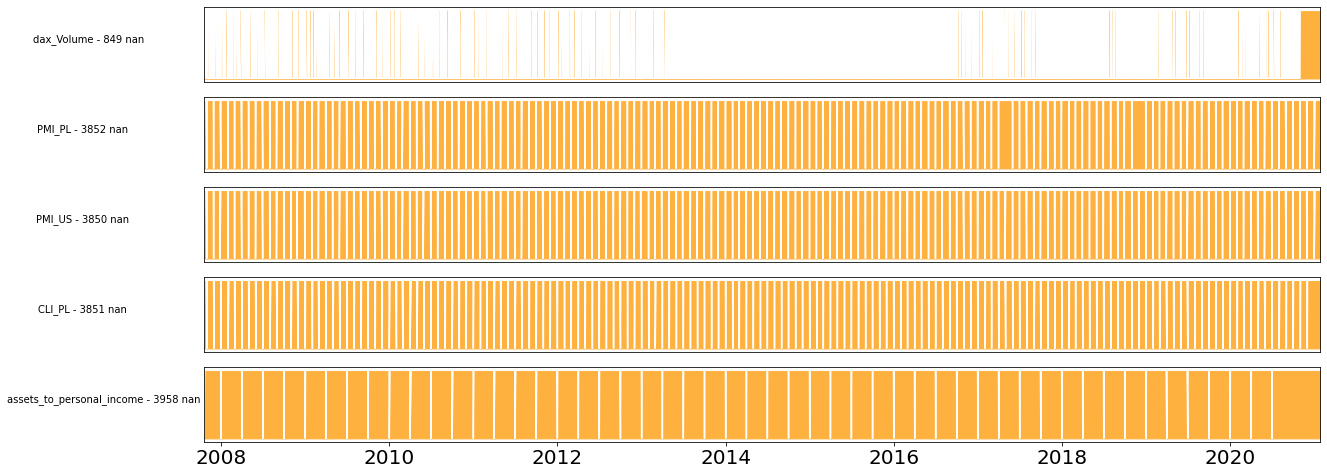

In [11]:
print('Missing values')

non_pure_columns = dataset.columns[(dataset.isna().sum()>824)]

fig = plt.figure(figsize=(20,8))
for column in range(len(non_pure_columns)):
    ax = fig.add_subplot(len(non_pure_columns),1,column+1)
    ax = plt.gca()
    ax.axes.yaxis.set_ticks([])
    ax.plot(dataset.index, dataset[non_pure_columns[column]].isna(), color='white')
    ax.fill_between(dataset.index, dataset[non_pure_columns[column]].isna(), color='#FFB13F')
    ax.get_xaxis().set_visible(False)
    missing = str(dataset[non_pure_columns[column]].isna().sum())
    y_name = non_pure_columns[column]+' - '+missing+' nan' + ' '*(20-len(non_pure_columns[column]))
    ax.set_ylabel(ylabel=y_name, rotation=0, loc='center', size=10, labelpad=100)
    ax.set_xlim([datetime.date(2007, 10, 19), datetime.date(2021, 1, 25)])

    
ax.get_xaxis().set_visible(True)
ax.xaxis.set_tick_params(labelsize=20)


plt.show()

In [14]:
class imput_missing_vallues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):

        return self
    
    def transform(self, X, y = None):
        
        X_copy = X.copy()

        columns = list(X_copy.columns)
        columns.remove('Close')
        columns
        for column in columns:
            X_copy[column] = X_copy[column].ffill()
        
        # 10-Year Poland Treasury Yield - 2-Year Poland Treasury Yield
        X_copy['PL10TY_PL2TY'] = X_copy['treasury_yield_10'] - X_copy['treasury_yield_2']
        X_copy.drop(['treasury_yield_10', 'treasury_yield_2'], axis=1, inplace=True)
        
        # Delete rows with Nan
        X_copy.dropna(subset=['Close'], how='all', inplace=True)
        
        return X_copy

In [15]:
steps = [
    ('imput_missing_vallues', imput_missing_vallues())
]
pipeline = Pipeline(steps = steps)
dataset_transformed = pipeline.fit_transform(dataset)
dataset_transformed

,Open,High,Low,Close,Volume,spx_Open,spx_High,spx_Low,spx_Close,spx_Volume,dax_Open,dax_High,dax_Low,dax_Close,dax_Volume,PMI_PL,PMI_US,CLI_PL,WIG_20_P/E,WIG_20_P/BV,WIG_20_DY,assets_to_personal_income,PL10TY_PL2TY
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-10-19,4379.67,4379.67,4379.67,4379.67,29456097.0,1540.08,1540.08,1500.26,1500.63,2.311650e+09,7895.52,7940.29,7870.73,7884.12,268825856.0,51.5,54.2,100.809682,21.958,3.741,2.055,5.123741,0.356
2007-10-22,4362.07,4362.07,4362.07,4362.07,37825830.0,1500.63,1508.06,1490.40,1506.33,1.928794e+09,7819.27,7819.27,7763.64,7794.93,294604256.0,51.5,54.2,100.809682,21.886,3.723,2.060,5.123741,0.307
2007-10-23,4476.13,4476.13,4476.13,4476.13,31809295.0,1506.33,1520.01,1503.61,1519.59,1.838400e+09,7822.89,7876.62,7822.89,7842.79,243051520.0,51.5,54.2,100.809682,22.344,3.799,2.005,5.123741,0.185
2007-10-24,4443.34,4443.34,4443.34,4443.34,26511409.0,1519.59,1519.59,1489.56,1515.88,2.224056e+09,7842.12,7861.27,7807.99,7828.96,257861712.0,51.5,54.2,100.809682,22.178,3.772,2.015,5.123741,0.119
2007-10-25,4468.73,4468.73,4468.73,4468.73,29651370.0,1515.88,1523.24,1500.46,1514.40,2.324422e+09,7862.60,7970.56,7861.39,7932.43,401154880.0,51.5,54.2,100.809682,22.141,3.765,1.985,5.123741,0.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,3746.76,3746.76,3626.70,3626.70,32703284.0,3781.88,3804.53,3780.37,3798.91,2.485142e+09,13935.93,13940.05,13804.46,13815.06,87347650.0,51.7,59.5,99.628343,24.783,1.426,0.655,5.570101,1.092
2021-01-20,3642.58,3655.91,3591.53,3637.63,26554080.0,3816.22,3859.75,3816.22,3851.85,2.350472e+09,13848.77,13952.20,13835.99,13921.37,87347650.0,51.7,59.5,99.628343,24.812,1.436,0.655,5.570101,1.107
2021-01-21,3669.81,3675.13,3569.97,3577.93,25603661.0,3857.46,3861.45,3845.05,3853.07,2.591056e+09,13997.78,14026.35,13878.84,13906.67,87347650.0,51.7,59.5,99.628343,24.465,1.405,0.670,5.570101,1.132


In [16]:
dataset_transformed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3214 entries, 2007-10-19 to 2021-01-25
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       3214 non-null   float64
 1   High                       3214 non-null   float64
 2   Low                        3214 non-null   float64
 3   Close                      3214 non-null   float64
 4   Volume                     3214 non-null   float64
 5   spx_Open                   3214 non-null   float64
 6   spx_High                   3214 non-null   float64
 7   spx_Low                    3214 non-null   float64
 8   spx_Close                  3214 non-null   float64
 9   spx_Volume                 3214 non-null   float64
 10  dax_Open                   3214 non-null   float64
 11  dax_High                   3214 non-null   float64
 12  dax_Low                    3214 non-null   float64
 13  dax_Close                  321

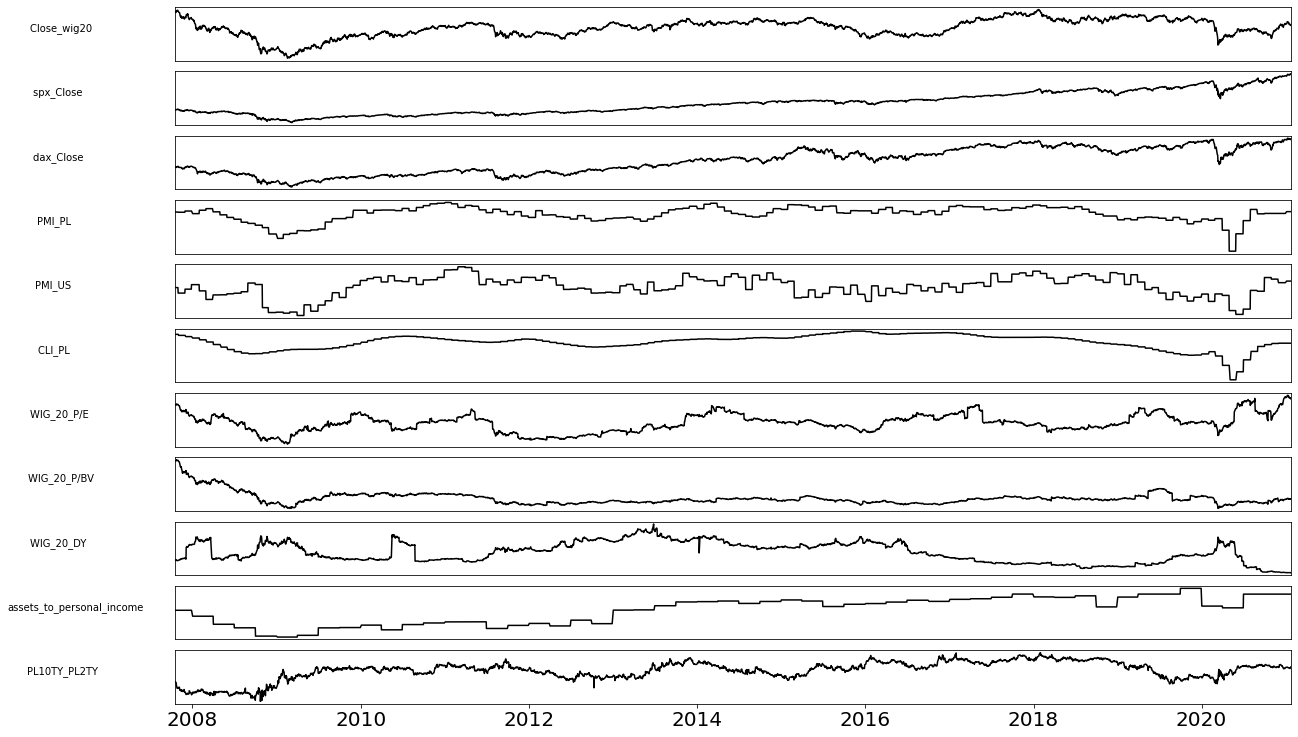

In [18]:
columns_to_plot = ['Close', 'spx_Close', 'dax_Close', 'PMI_PL', 'PMI_US', 'CLI_PL', 'WIG_20_P/E', 
                   'WIG_20_P/BV', 'WIG_20_DY', 'assets_to_personal_income', 'PL10TY_PL2TY']

fig = plt.figure(figsize=(20, 14))
for column in range(len(columns_to_plot)):

    ax = fig.add_subplot(len(columns_to_plot)+1,1,column+1)
    ax = plt.gca()
    ax.axes.yaxis.set_ticks([])
    ax.plot(dataset_transformed.index, dataset_transformed[columns_to_plot[column]], color='black')
    ax.get_xaxis().set_visible(False)
    ax.set_xlim([datetime.date(2007, 10, 19), datetime.date(2021, 1, 25)])
    y_name = columns_to_plot[column] + ' '*(20-len(columns_to_plot[column]))
    if columns_to_plot[column] == 'Close':
        y_name = 'Close_wig20' + ' '*(20-len('Close_wig20'))
    ax.set_ylabel(ylabel=y_name, rotation=0, loc='center', size=10, labelpad=100)

ax.get_xaxis().set_visible(True)
ax.xaxis.set_tick_params(labelsize=20)
plt.show()

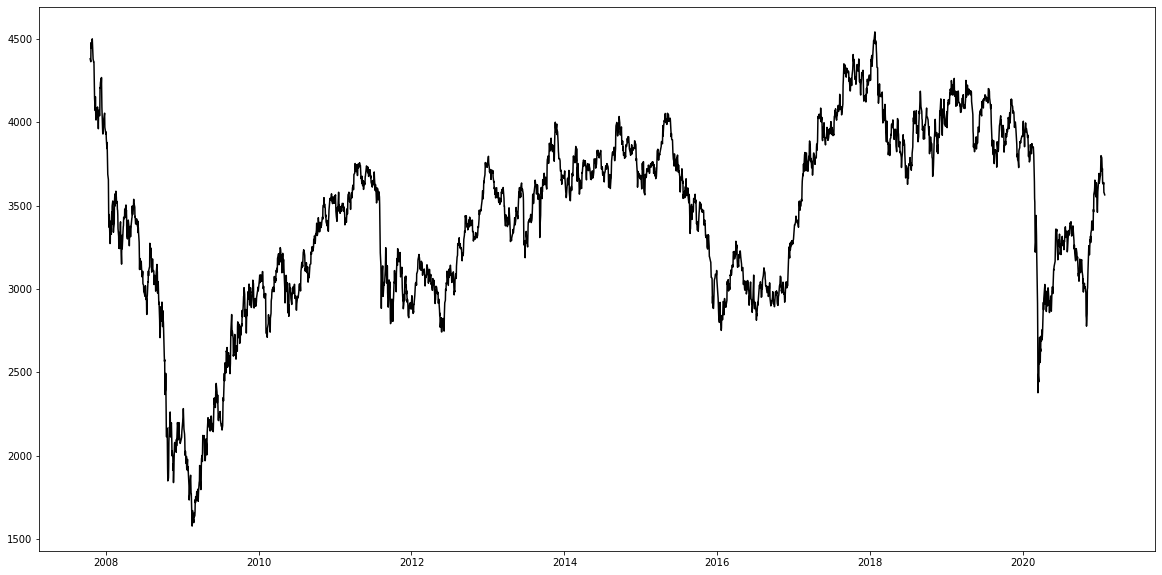

In [25]:
plt.figure(figsize=(20,10))
plt.plot(dataset_transformed['Close'], color='black')
plt.show()

In [20]:
dataset_transformed.to_csv('data/dataset/dataset.csv')